# Inference on the test dataset using the fine-tuned SegFormer model

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# set path
%cd '/content/gdrive/MyDrive/Speciale'

/content/gdrive/MyDrive/Speciale


In [ ]:
# Install packages
!pip -q install datasets==2.3.2
!pip -q install huggingface-hub
!pip install git+https://github.com/huggingface/transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.3/362.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import dependencies

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from transformers import (SegformerFeatureExtractor, TFSegformerForSemanticSegmentation)

import datasets
import glob
from pathlib import Path

import cv2
import os

from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
# set path to image/mask and create dataset
# feature_extraction_utils-py expects the input to have a specfic format, the dataset is threrefore loaded this way.

IMAGES = glob.glob(str(Path("datasets/images/test/*.jpg")))
SEG_MAPS = glob.glob(str(Path("datasets/mask/test/*.png")))
test_dataset = datasets.Dataset.from_dict({"pixel_values": IMAGES, "label": SEG_MAPS}, features=datasets.Features({"pixel_values": datasets.Image(), "label": datasets.Image()}))

In [ ]:
test_dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 33
})

In [ ]:
# Load the finetuned model as pretrained_model
finetuned_model_ckpt = "models/aug2_20_epoch"
pretrained_model = TFSegformerForSemanticSegmentation.from_pretrained(finetuned_model_ckpt)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at models/aug2_20_epoch.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


#Predict segmentation mask for one image

In [ ]:
# functions for preprocessing using SegFormer Feature Extractor
# Note that do_normalize are set to False due to some weird bug in the fine-tune process. Please look in the 'finetune_SegFormer' notebook for more details

feature_extractor = SegformerFeatureExtractor(do_normalize=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
test_image = test_dataset[5]['pixel_values']
test_gt = test_dataset[5]['label']

In [ ]:
# extract features for the test image
inputs = feature_extractor(images=test_image, return_tensors="tf")
print(inputs["pixel_values"].shape)

(1, 3, 512, 512)


In [ ]:
# resize the logits to fit the original size of the image/mask

outputs = pretrained_model(**inputs)
logits = outputs.logits  # shape of (batch_size, num_labels, height/4, width/4)

# Transpose to have the shape (batch_size, height/4, width/4, num_labels)
logits = tf.transpose(logits, [0, 2, 3, 1])

# Rescale logits to the original image size
upsampled_logits = tf.image.resize(
    logits,
    test_image.size[::-1])  # Reverse the shape of `image` because `image.size` returns width and height.

# Apply argmax on the class dimension
pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]
print(pred_seg.shape)

(512, 512)


In [ ]:
# Define a palette to color the three classes

def get_palette():
    """palette that maps each class to RGB values."""
    return [
        [255, 255, 0],
        [0, 255, 0],
        [255, 0, 0]
    ]

In [ ]:
# create function to overlay mask and image

def get_seg_overlay(image, seg):
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8)  # height, width, 3
    palette = np.array(get_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

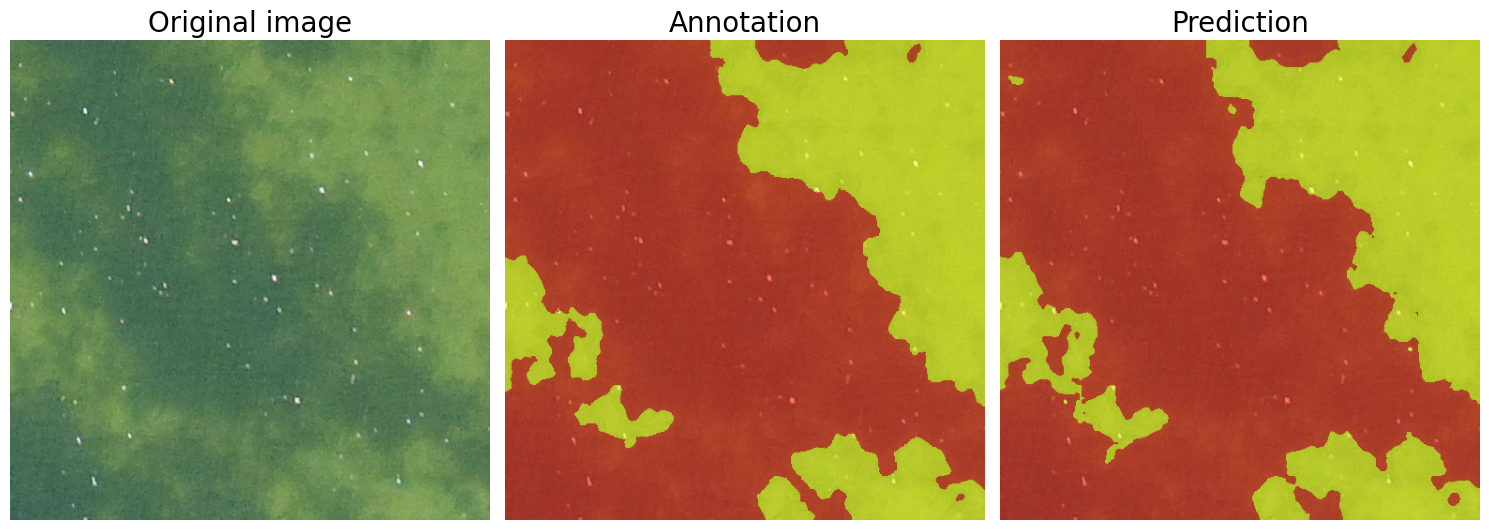

In [ ]:
pred_img = get_seg_overlay(test_image, pred_seg.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 3)
f.set_figheight(15)
f.set_figwidth(15)

axs[0].set_title("Original image", {"fontsize": 20})
axs[0].imshow(test_image)
axs[0].axis("off")
axs[1].set_title("Annotation", {"fontsize": 20})
axs[1].imshow(gt_img)
axs[1].axis("off")
axs[2].set_title("Prediction", {"fontsize": 20})
axs[2].imshow(pred_img)
axs[2].axis("off")

plt.tight_layout()
plt.show()

#Predict segmentation mask for the test dataset

In [ ]:
# Predict segmentation masks for the testset

# define directories for predicted masks and the overlay img
predicted_masks_dir = 'inference/predicted_masks'
overlay_dir = 'inference/overlay'
annotation_dir = 'inference/annotations'
os.makedirs(predicted_masks_dir, exist_ok=True)
os.makedirs(overlay_dir, exist_ok=True)
os.makedirs(annotation_dir, exist_ok=True)

# iterate over the images in the test_dataset
for i, index_number in enumerate(test_dataset):
  test_image = index_number['pixel_values']
  annotation = index_number['label']
  annotation_array = np.array(annotation)

  # extract features and predict segmentation
  inputs = feature_extractor(images=test_image, return_tensors="tf")
  outputs = pretrained_model(**inputs)
  logits = outputs.logits
  logits = tf.transpose(logits, [0, 2, 3, 1])
  upsampled_logits = tf.image.resize(logits, test_image.size[::-1])
  pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]
  pred_img = get_seg_overlay(test_image, pred_seg.numpy())

  # create filename
  filename_pred_seg = f'predicted_{i}.png'
  filename_pred_img = f'overlay_{i}.png'
  filename_annotation = f'annotation_{i}.png'

  # create path
  path1 = os.path.join(predicted_masks_dir, filename_pred_seg)
  path2 = os.path.join(overlay_dir, filename_pred_img)
  path3 = os.path.join(annotation_dir, filename_annotation)

  # save predicted mask and overlay image
  cv2.imwrite(path1, pred_seg.numpy())
  cv2.imwrite(path2, pred_img)
  cv2.imwrite(path3, annotation_array)

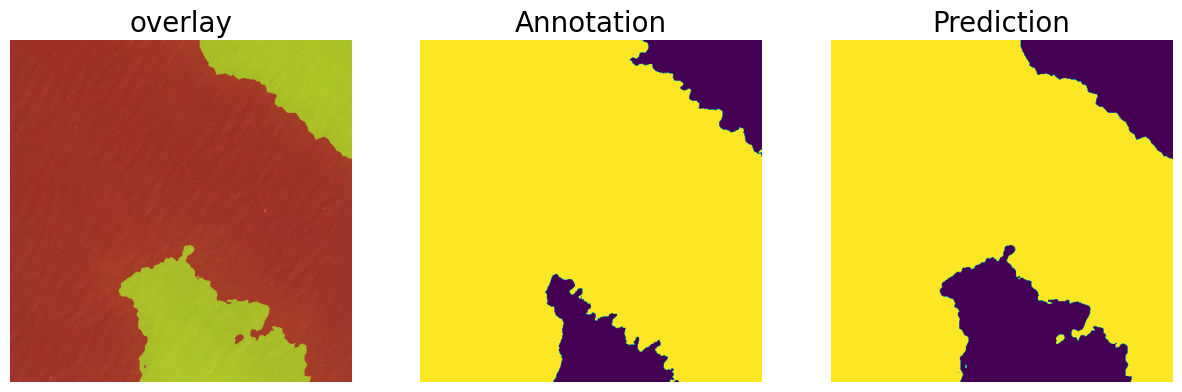

In [ ]:
# view overlay, annotation and prediction to see if everything is okay

pred_mask = cv2.imread('inference/predicted_masks/predicted_3.png', cv2.IMREAD_GRAYSCALE)
annotation = cv2.imread('inference/annotations/annotation_3.png', cv2.IMREAD_GRAYSCALE)
overlay = cv2.imread('inference/overlay/overlay_3.png')

f, axs = plt.subplots(1, 3)
f.set_figheight(15)
f.set_figwidth(15)

axs[0].set_title("overlay", {"fontsize": 20})
axs[0].imshow(overlay)
axs[0].axis("off")
axs[1].set_title("Annotation", {"fontsize": 20})
axs[1].imshow(annotation)
axs[1].axis("off")
axs[2].set_title("Prediction", {"fontsize": 20})
axs[2].imshow(pred_mask)
axs[2].axis("off")

plt.show()



#Compute metrics for one image

In [ ]:
# flatten the annotation mask and predicted mask to calculate metrics

annotation_1D = tf.reshape(annotation, [-1])
predicted_mask_1D = tf.reshape(pred_mask, [-1])
print(tf.shape(annotation_1D))
print(tf.shape(annotation))
print(tf.shape(predicted_mask_1D))
print(tf.shape(pred_mask))

tf.Tensor([262144], shape=(1,), dtype=int32)
tf.Tensor([512 512], shape=(2,), dtype=int32)
tf.Tensor([262144], shape=(1,), dtype=int32)
tf.Tensor([512 512], shape=(2,), dtype=int32)


In [ ]:
# confusion matrix tensorflow
cm = tf.math.confusion_matrix(annotation_1D, predicted_mask_1D)
print(f'confusion matrix - tensorflow: \n{cm}')

confusion matrix - tensorflow: 
[[185632    110    138]
 [  2903  73068      0]
 [   111      0    182]]


In [ ]:
# confusion matrix sklearn
cm = confusion_matrix(annotation_1D, predicted_mask_1D)
print(f'confusion matrix - sklearn: \n{cm}')

confusion matrix - sklearn: 
[[185632    110    138]
 [  2903  73068      0]
 [   111      0    182]]


In [ ]:
#calculate accuracy from True positives and True negatives
TP = tf.keras.metrics.TruePositives()
TP.update_state(annotation_1D, predicted_mask_1D)
TN = tf.keras.metrics.TrueNegatives()
TN.update_state(annotation_1D, predicted_mask_1D)
total_inputs = len(annotation_1D)

print(total_inputs)
print('True positive: ', round(TP.result().numpy(),4))
print('True negative: ', round(TN.result().numpy(),4))
print('Accuracy: ', round((TP.result().numpy() + TN.result().numpy())/ total_inputs, 4))


262144
True positive:  73250.0
True negative:  185632.0
Accuracy:  0.9876


In [ ]:
# Accuracy - tensorflow
predicted_accuracy = tf.keras.metrics.Accuracy()
predicted_accuracy.update_state(annotation_1D, predicted_mask_1D)
print('accuracy: ', round(predicted_accuracy.result().numpy(),4))

accuracy:  0.9876


In [ ]:
# precission
predicted_precision = tf.keras.metrics.Precision()
predicted_precision.update_state(annotation_1D, predicted_mask_1D )
print('precission: ', round(predicted_precision.result().numpy(),4))

precission:  0.9966


In [ ]:
# recall
predicted_recall = tf.keras.metrics.Recall()
predicted_recall.update_state(annotation_1D, predicted_mask_1D )
print('recall: ', round(predicted_recall.result().numpy(),4))

recall:  0.9605


In [ ]:
# F1 score (dice)

# convert data into the right format
annotation_int32 = tf.cast(annotation, tf.int32)
predicted_mask_int32 = tf.cast(pred_mask, tf.int32)

# flatten
mask_true_flat = tf.reshape(annotation_int32, [-1])
mask_pred_flat = tf.reshape(predicted_mask_int32, [-1])

# Convert to numpy array
mask_true_np = mask_true_flat.numpy()
mask_pred_np = mask_pred_flat.numpy()

# Calculate F1 score
f1 = f1_score(mask_true_np, mask_pred_np, average='micro')

print('F1 Score:', round(f1, 4))

F1 Score: 0.9876


In [ ]:
# mIoU
mean_iou = tf.keras.metrics.MeanIoU(num_classes=3)
mean_iou.update_state(annotation_1D, predicted_mask_1D)
print('mIoU: ', round(mean_iou.result().numpy(), 4))

mIoU:  0.7885


In [ ]:
# IoU background class
iou_background = tf.keras.metrics.IoU(num_classes=3, target_class_ids=[0])
iou_background.update_state(annotation_1D, predicted_mask_1D)
print('IoU background: ', round(iou_background.result().numpy(), 4))

IoU background:  0.9827


In [ ]:
# IoU eelgrass
iou_eelgrass = tf.keras.metrics.IoU(num_classes=3, target_class_ids=[1])
iou_eelgrass.update_state(annotation_1D, predicted_mask_1D)
print('IoU eelgrass: ', round(iou_eelgrass.result().numpy(), 4))

IoU eelgrass:  0.9604


In [ ]:
# IoU macroalgae
iou_macroalgae = tf.keras.metrics.IoU(num_classes=3, target_class_ids=[2])
iou_macroalgae.update_state(annotation_1D, predicted_mask_1D)
print('IoU macroalgae: ', round(iou_macroalgae.result().numpy(), 4))

IoU macroalgae:  0.4223


#Compute metrics for the test dataset

In [ ]:
# create lists of the predicted masks and corresponding annotations

# Define directories
predicted_masks_dir = 'inference/predicted_masks'
annotation_dir = 'inference/annotations'

# Initialize lists to store the masks
predicted_masks = []
annotation_masks = []

# Sort the filenames in the directories
predicted_mask_filenames = sorted(os.listdir(predicted_masks_dir))
annotation_filenames = sorted(os.listdir(annotation_dir))

# Iterate over the sorted files in the predicted masks directory and append to list
for filename in predicted_mask_filenames:
    mask = cv2.imread(os.path.join(predicted_masks_dir, filename), cv2.IMREAD_GRAYSCALE)
    predicted_masks.append(mask)

# Iterate over the sorted files in the annotation masks directory and append to list
for filename in annotation_filenames:
    mask = cv2.imread(os.path.join(annotation_dir, filename), cv2.IMREAD_GRAYSCALE)
    annotation_masks.append(mask)


In [ ]:

# Initialize variables to accumulate intersection and union for each class
intersection = np.zeros(3)
union = np.zeros(3)

# Iterate over predicted masks and annotation masks and compute confusion matrix
for pred_mask, ground_truth_mask in zip(predicted_masks, annotation_masks):

    # Calculate confusion matrix
    cm = confusion_matrix(ground_truth_mask.flatten(), pred_mask.flatten(), labels=range(3))

    # Calculate intersection and union for each class
    intersection += np.diag(cm)
    union += np.sum(cm, axis=0) + np.sum(cm, axis=1) - np.diag(cm)

# Calculate IoU for each class
iou_per_class = intersection / union

# Calculate mean IoU
mIOU = np.mean(iou_per_class)



# Flatten masks to calculate accuracy, precision, recall
predicted_masks_flat = np.concatenate([pred_mask.flatten() for pred_mask in predicted_masks])
ground_truth_masks_flat = np.concatenate([ground_truth_mask.flatten() for ground_truth_mask in annotation_masks])

# calculate accuracy for test dataset
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(ground_truth_masks_flat, predicted_masks_flat)

# calculate precision
precision = tf.keras.metrics.Precision()
precision.update_state(ground_truth_masks_flat, predicted_masks_flat)

# calculate recall
recall = tf.keras.metrics.Recall()
recall.update_state(ground_truth_masks_flat, predicted_masks_flat)

# calculate F1 score (dice score)
predicted_masks_flat_int32 = tf.cast((predicted_masks_flat), tf.int32)
ground_truth_masks_flat_int32 = tf.cast((ground_truth_masks_flat), tf.int32)

# Convert to numpy array and calculate F1
mask_true_np = ground_truth_masks_flat_int32.numpy()
mask_pred_np = predicted_masks_flat_int32.numpy()

f1 = f1_score(mask_true_np, mask_pred_np, average='macro')

print('F1 Score:', round(f1, 4))
print('recall: ', round(recall.result().numpy(),4))
print('precission: ', round(precision.result().numpy(),4))
print('accuracy: ', round(accuracy.result().numpy(),4))
print('mIOU:', round(mIOU, 4))
print('Background IoU:', round(iou_per_class[0], 4))
print('Eelgrass IoU:', round(iou_per_class[1], 4))
print('Macroalgae IoU:', round(iou_per_class[2], 4))


F1 Score: 0.9694
recall:  0.9653
precission:  0.9703
accuracy:  0.9736
mIOU: 0.9407
Background IoU: 0.9598
Eelgrass IoU: 0.9289
Macroalgae IoU: 0.9335
